<a href="https://colab.research.google.com/github/joshua-fire/awesome-computer-vision/blob/master/elhashimi%20team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd

In [0]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
data = pd.read_csv('/content/drive/My Drive/datta.csv',encoding="utf8")
data.head(10)

,word,pos,tag,sentence_idx
0,Il,PRO:PER,O,1
1,assure,VER:pres,O,1
2,à,VER:pper,O,1
3,la,DET:ART,O,1
4,suite,NOM,O,1
5,de,PRP,I-PER,1
6,Saussure,NAM,I-PER,1
7,le,DET:ART,O,1
8,cours,NOM,O,1
9,de,PRP,O,1


In [0]:
BATCH_SIZE = 512  # Number of examples used in each iteration
EPOCHS = 5  # Number of passes through entire dataset
MAX_LEN = 80  # Max length of review (in words)
EMBEDDING = 40  # Dimension of word embedding vector


In [37]:
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['sentence_idx'])))

words = list(set(data["word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.tail(100)

Number of sentences:  122055
Number of words in the dataset:  103032
Tags: ['I-MISC', 'O', 'B-LOC', 'I-ORG', 'I-PER', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC']
Number of Labels:  9
What the dataset looks like:


,word,pos,tag,sentence_idx
2777298,",",PUN,I-MISC,133868
2777299,le,DET:ART,I-MISC,133868
2777300,roi,NOM,I-MISC,133868
2777301,barbare,ADJ,I-MISC,133868
2777302,",",PUN,O,133868
...,...,...,...,...
2777393,la,DET:ART,O,133871
2777394,Grèce,NAM,I-MISC,133871
2777395,antique,ADJ,I-MISC,133871
2777396,",",PUN,O,133871


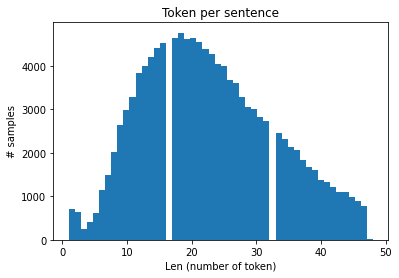

In [12]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()

# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()


In [0]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding
# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

In [14]:
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
idx2tag

{0: 'PAD',
 1: 'I-MISC',
 2: 'O',
 3: 'B-LOC',
 4: 'I-ORG',
 5: 'I-PER',
 6: 'B-MISC',
 7: 'B-ORG',
 8: 'B-PER',
 9: 'I-LOC'}

In [15]:
from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

Raw Sample:  Il assure à la suite de Saussure le cours de grammaire comparée , qu' il complète à partir de 1894 par une conférence sur l' iranien
Raw Label:  O O O O O I-PER I-PER O O O O O O O O O O O O O O O O O O O
After processing, sample: [26764  6065 13574 99751 75802 78581 81139 27367 71150 78581 95224 17475
 75832 14033 35877 29847 13574 29863 78581 10317 14644  6548 24630  1465
 98463 80871     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
After processing, labels: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 

In [18]:
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

In [20]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)# a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 80, 40)            4121360   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 100)           36400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 80, 50)            5050      
_________________________________________________________________
crf_3 (CRF)                  (None, 80, 10)            630       
Total params: 4,163,440
Trainable params: 4,163,440
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 98864 samples, validate on 10985 samples
Epoch 1/5
 - 182s - loss: 0.2162 - crf_viterbi_accuracy: 0.9388 - val_loss: 0.0747 - val_crf_viterbi_accuracy: 0.9769
Epoch 2/5
 - 176s - loss: 0.0556 - crf_viterbi_accuracy: 0.9817 - val_loss: 0.0450 - val_crf_viterbi_accuracy: 0.9850
Epoch 3/5
 - 177s - loss: 0.0321 - crf_viterbi_accuracy: 0.9891 - val_loss: 0.0310 - val_crf_viterbi_accuracy: 0.9888
Epoch 4/5
 - 180s - loss: 0.0205 - crf_viterbi_accuracy: 0.9921 - val_loss: 0.0221 - val_crf_viterbi_accuracy: 0.9908
Epoch 5/5
 - 176s - loss: 0.0133 - crf_viterbi_accuracy: 0.9936 - val_loss: 0.0181 - val_crf_viterbi_accuracy: 0.9910


In [0]:
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [36]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00        17
      B-MISC       0.00      0.00      0.00         7
       B-PER       0.00      0.00      0.00         7
       I-LOC       0.77      0.92      0.84     14060
      I-MISC       0.87      0.63      0.73      6965
       I-ORG       0.87      0.67      0.76      3816
       I-PER       0.93      0.93      0.93     10461
           O       0.99      0.99      0.99    241347
         PAD       1.00      1.00      1.00    699800

    accuracy                           0.99    976480
   macro avg       0.60      0.57      0.58    976480
weighted avg       0.99      0.99      0.99    976480

